### Model building

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', 1000) # shows all the columns
pd.set_option('display.float_format', lambda x: '%.4f' % x) # displays outputs with 1 decimal
pd.set_option('display.max_rows', 10000) # shows all the rows
%matplotlib inline

### Creating a baseline model using the median of house price across the zipcode groups
-- this is the most simple prediction of a house price. When no ML model is in place, the price of a house is the median price of all the houses in that zipcode group to which this house belongs. 
#### The evaluation metric for the model used is Mean Absolute error which measures how far away is our prediction in target variable's units which is dollar ($) in our case

- After running the below code, we see the MAE of the baseline model is 147222  which explains that our baseline model prediction of a house price is on average a $147K far from actual price

In [50]:
zipcode_median_price=data3.groupby('zipcode_group')['price'].median()
zipcode_median_price_dict=zipcode_median_price.to_dict()
data4['zip_median_price'] = data3['zipcode_group'].map(zipcode_median_price_dict)
drop_vars2=['id', 'date','price','zip_median_price']
features=data4.drop(drop_vars2,axis=1)
target=data4[['price','zip_median_price']]
X_train, X_validation, y_train, y_validation = train_test_split(features,target, test_size=0.30, random_state=42,shuffle = True)
y_validation2=y_validation['price']
y_pred=y_validation['zip_median_price']
print("MAE for the baseline model tested on test set : ",mean_absolute_error(y_validation2, y_pred))

MAE for the baseline model tested on test set :  147222.607593885


#### To further improve this model, we now introduce complex models in order to achieve better predictions. Since this is a regression task, we have chosen Linear Regression, Decision Tree, Random Forest and Gradient Boosting

**Splitting the main data into train and validation data, where we finalise the model using the training data and finally use the validation data to see how our model performs on unseen data. This is important so that we know, how our model makes prediction on the price, when a new house with these features comes into the market**

### Final data and train-test-split

In [51]:
drop_vars3=['zip_median_price']
data5=data4.drop(drop_vars3,axis=1)

In the below code, we now split the data in training and validation sets. Keeping 70% of the data as training and keeping aside 30% for validation to check how our model performs on never-seen data.

In [190]:
feature=data5.iloc[:,3:]                 
target=data5['price']
X_train, X_validation, y_train, y_validation = train_test_split(features,target, test_size=0.30, random_state=42,shuffle = True)

In [191]:
# The number of observations and columns in the train and validation datasets
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((14042, 49), (6018, 49), (14042,), (6018,))

###  Spot-Check of Algorithms

Here we are trying to see which algorithms out of the four ( Linear Regression, Decision Tree, Random Forest and Gradient Boosting) will predict the best with lowest error. We cross validate our training data with 5 folds, get errors on each fold, and finally average those error so that we are really sure how the model performs for every record of the data. There can be variation in the distribution of the data and so cross validation is a preventive measure in overfitting of the model.

#### Create model container and add models to it

In [52]:
#defining the model container
class ModelContainer:
    def __init__(self, models=[]):
        '''initializes model list and dicts'''
        self.models = models
        self.best_model = None
        self.mean_mae = {}
        
    def add_model(self, model):
        self.models.append(model)

    def cross_validate(self):
    
        '''cross validate models using given data'''
        for model in self.models:
            neg_mae = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
            self.mean_mae[model] = abs(neg_mae.mean())
    def select_best_model(self):
        '''select model with lowest mae'''
        self.best_model = min(self.mean_mae, key=self.mean_mae.get)
        
    def best_model_fit(self, x_features, target):
        '''fits best model'''
        self.best_model.fit(x_features, target)
    
    def print_summary(self):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        for model in models.mean_mae:
            print('\n', model, '- MAE:', models.mean_mae[model])
        print('\nBest Model:\n', models.best_model)

In [194]:
#creating model container
models = ModelContainer()
models.add_model(LinearRegression())
models.add_model(DecisionTreeRegressor(random_state=42))
models.add_model(RandomForestRegressor(random_state=42))
models.add_model(GradientBoostingRegressor(random_state=42))

#### Cross validate models,and select the best model

In [195]:
models.cross_validate() 
models.select_best_model()
models.print_summary()


Model Summaries:


 LinearRegression() - MAE: 75810.6638733691

 DecisionTreeRegressor(random_state=42) - MAE: 75808.14602678713

 RandomForestRegressor(random_state=42) - MAE: 52940.237496269365

 GradientBoostingRegressor(random_state=42) - MAE: 57830.4770664954

Best Model:
 RandomForestRegressor(random_state=42)


**From the above exercise, we see that Random Forest works the best for our data with the lowest MAE. This means our prediction is on average just $52K away from our prediction**

We will now move on with hypertuning the parameters of Random Forest. Model hyperparametrs tell us how the model is structured , it controls the behaviour of the training algorithm. There is no one specific way on how to tune hyperparameters, but the best way is to use GridSearchCV. Here we define multiple values for the hyperparameters and the GridSearch chooses the best hyperparameter values based on the lowest Mean Absolute Error

### Hypertuning the Random Forest model and getting the final prediction on the test dataset

In [196]:
# Number of trees in random forest
n_estimators=[100,200,300]
# Number of features to consider at every split
max_features = [ 0.7, 0.2]
# Maximum number of levels in tree
max_depth = [10,20 ]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2]
# Creating the random grid
param_grid = {'n_estimators': n_estimators, 'max_features': max_features,'max_depth': max_depth, 
              'min_samples_leaf': min_samples_leaf  }
rf_grid=GridSearchCV(estimator =models.best_model,param_grid=param_grid,scoring='neg_mean_absolute_error', 
                     n_jobs=-1, cv=5, verbose=2)
# Fit the random search model on training data and getting the best estimator
rf_grid.fit(X_train, y_train)
best_fit=rf_grid.best_estimator_
best_fit

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.7min finished


RandomForestRegressor(max_depth=20, max_features=0.7, n_estimators=300,
                      random_state=42)

Now, we fit our training data with the best estimator and test it on the validation/unseen data

In [197]:
# Fitting the training data with the best estimator ans getting the mean square error
best_fit.fit(X_train, y_train)
y_pred=best_fit.predict(X_validation)
# calculating the mean absolute error
print(mean_absolute_error(y_validation, y_pred))
feature_imp=best_fit.feature_importances_

51207.258987008594


In [198]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_validation, y_pred)

0.8623494302271479

The above exercise tells us that the after tuning the hyperparameters and then testing on unseen data, the **final RF model's prediction is just a $51K away  from the actual value of the house**. Also, the **model explains 86% of the variablity of price across the dataset.**

Also plotting the residuals, that is plotting the predicted and actual values, we see there is positive correlation between them. For a good fit, the points should be close to the fitted line. There are few outliers, which means that some predictions are inaccurate, however the positive correlation demostrates an overall good fit.

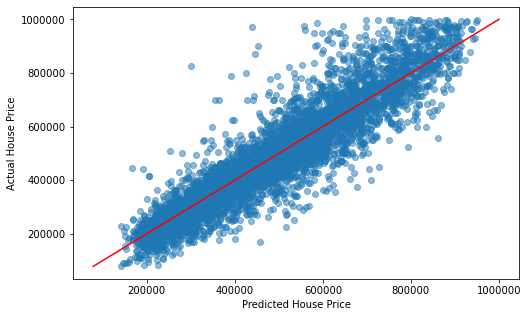

In [208]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred,y_validation,alpha=.5)
plt.xlabel("Predicted House Price")
plt.ylabel("Actual House Price")
p1 = max(max(y_pred), max(y_validation))
p2 = min(min(y_pred), min(y_validation))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.ticklabel_format(style='plain', axis='x') ;
plt.ticklabel_format(style='plain', axis='y') ;

### Important features of the model

After fitting the model, we now look for which features has contributed the most to this model. Investors can take an account of this and pay greater attention to these features while investing in selling a house or acquiring a house in the King County

We see that features like latitude and longitude i.e the location of the house,the size of the interior living area, grade and condition of the house,  and average size of a room are important room to look a while predicting the house price at King County

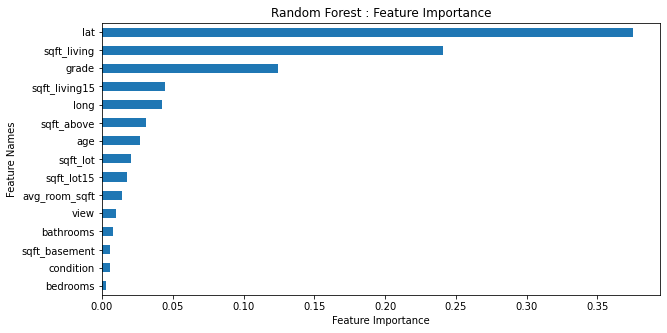

In [234]:
plt.figure(figsize=(10,5))
(pd.Series(feature_imp, index=X_train.columns).nlargest(15).plot(kind='barh')).invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names");
plt.title("Random Forest : Feature Importance");